In [1]:
import os
import statistics
import sys
import nengo
import keras
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nengo_dl
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, ShuffleSplit
from tensorflow.python.keras import Input, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense

In [2]:
# global config
dataset_path = os.path.join('..', 'datasets', 'VarekaGTNEpochs.mat')
os.makedirs('nengo', exist_ok=True)

# set seed for consistent result
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
def get_dataset(file = dataset_path):
    """
    Helper function to get dataset from file
    """

    np_file = loadmat(file) # load dataset file with matrices
    target_data, non_target_data = np_file['allTargetData'], np_file['allNonTargetData'] # get target and non-target data
    features = np.concatenate((target_data, non_target_data)) # concatenate target and non-target into features

    # target labels are represented as (1, 0) vector, non target labels are represented as (0, 1) vector
    target_labels = np.tile(np.array([1, 0]), (target_data.shape[0], 1)) # set 'target' as (1, 0) vector
    non_target_labels = np.tile(np.array([0, 1]), (non_target_data.shape[0], 1)) # set 'non target' as (0, 1) vector
    labels = np.vstack((target_labels, non_target_labels)) # concatenate target and non target labels

    # filter noise above 100 mV
    threshold = 100.0
    result_x, result_y = [], []
    for i in range(features.shape[0]):
        if not np.max(np.abs(features[i])) > threshold:
            result_x.append(features[i])
            result_y.append(labels[i])

    features, labels = np.array(result_x), np.array(result_y)
    features = features.reshape((features.shape[0], 1, -1))
    labels = labels.reshape((labels.shape[0], 1, -1))
    print('features:', features, features.shape)
    print('labels:', labels, labels.shape)
    return features, labels

In [4]:
def create_model():
    """
    Function to create tensorflow model
    """
    inp = Input(shape=(3, 1200, 1), name='input_layer')
    conv2d = Conv2D(filters=6, kernel_size=(3, 3), activation=tf.nn.relu)(inp)
    dropout1 = Dropout(0.5, seed=0)(conv2d)
    avg_pooling = AveragePooling2D(pool_size=(1, 8), padding='same')(dropout1)
    flatten = Flatten()(avg_pooling)
    dense1 = Dense(100, activation=tf.nn.relu)(flatten)
    batch_norm = BatchNormalization()(dense1)
    dropout2 = Dropout(0.5, seed=0)(batch_norm)
    output = Dense(2, activation=tf.nn.softmax, name='output_layer')(dropout2)

    return Model(inputs=inp, outputs=output)

In [5]:
features, labels = get_dataset()
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=.25, random_state=seed, shuffle=True)

print('train_x: {}, shape: {}, train_y: {}, shape: {}'.format(train_x, train_x.shape, train_y, train_y.shape))
print('test_x: {}, shape: {}, test_y: {}, shape: {}'.format(test_x, test_x.shape, test_y, test_y.shape))

ann, snn = [], []
iter = 1
monte_carlo = ShuffleSplit(n_splits=15, test_size=.25, random_state=seed)
for train, validation in monte_carlo.split(train_x):

    print('iteration {}'.format(iter))
    print('train: {}, validation: {}'.format(train, validation))

    curr_train_x, curr_train_y = train_x[train], train_y[train]
    curr_valid_x, curr_valid_y = train_x[validation], train_y[validation]

    params_output = os.path.join('nengo','params_iter_{}'.format(iter))

    # callback for early stopping if network does not improve within next 5 epochs
    early_stop = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

    model = create_model() # create keras model
    converter = nengo_dl.Converter(model)

    # run ann with nengo
    with nengo_dl.Simulator(converter.net, minibatch_size=32) as simulator:
        simulator.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
        )

        input_layer = converter.inputs[model.get_layer('input_layer')]
        output_layer = converter.outputs[model.get_layer('output_layer')]

        simulator.fit({input_layer: curr_train_x}, {output_layer: curr_train_y},
                                validation_data=(curr_valid_x, curr_valid_y),
                                epochs=30,
                                shuffle=True,  # delete later to see if it makes any difference
                                callbacks=[early_stop]
                                )

        current_ann_result = simulator.evaluate({input_layer: test_x}, {output_layer: test_y})
        simulator.save_params(params_output)

        print('{}. ann accuracy {:5f}%'.format(iter, current_ann_result['probe_accuracy'] * 100))
        ann.append(current_ann_result['probe_accuracy'])

    # run snn with nengo
    timesteps = 30
    converter = nengo_dl.Converter(model=model,
                                   swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                                   scale_firing_rates=1000, synapse=0.01)

    with converter.net:
        nengo_dl.configure_settings(stateful=False)

    input_layer = converter.inputs[model.get_layer('input_layer')]
    output_layer = converter.outputs[model.get_layer('output_layer')]

    time_tiled_x = np.tile(test_x, (1, timesteps, 1))

    with nengo_dl.Simulator(converter.net, minibatch_size=41, progress_bar=False) as simulator:
        simulator.load_params(params_output)

        #WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function
        # at 0x000001A346CB9820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings
        # could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes,
        # (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop.
        # For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid
        # unnecessary retracing. For (3), please refer to
        # https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args
        # and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

        with converter.net:
            nengo_dl.configure_settings(stateful=False)

        predictions = simulator.predict({input_layer: time_tiled_x})

        predictions = predictions[output_layer]
        # slice all except for last timestep and get argmax of it
        predictions = predictions[:, -1, :]

        predictions = np.argmax(predictions, axis=-1)

        transformed_test_y = np.squeeze(test_y, axis=1)
        transformed_test_y = np.argmax(transformed_test_y, axis=-1)

        snn_avg = (predictions == transformed_test_y).mean()
        snn.append(snn_avg)
        print('{}. snn accuracy {:5f}%'.format(iter, snn_avg * 100))

    tf.keras.backend.clear_session() # clear session not to run out of memory
    iter += 1

features: [[[ -0.77055806  -0.76216829  -0.75329262 ...   0.9730792    1.04828787
     1.00901747]]

 [[  4.72857332   4.79228735   4.86664867 ... -15.98517323 -16.30454826
   -16.64167595]]

 [[ -2.2145133   -1.49968874  -0.77021754 ...  -6.05920124  -5.69483948
    -5.42987347]]

 ...

 [[  9.08650398   9.06958485   9.0740099  ...  18.27712059  17.41079521
    16.49032021]]

 [[  3.50287008   2.95584893   2.36093497 ...  20.93103218  21.30741882
    21.62874603]]

 [[-14.8089571  -14.57761955 -14.33197689 ...  32.55890274  32.86030197
    33.12610626]]] (8036, 1, 3600)
labels: [[[1 0]]

 [[1 0]]

 [[1 0]]

 ...

 [[0 1]]

 [[0 1]]

 [[0 1]]] (8036, 1, 2)
train_x: [[[ -0.5420959   -1.21452522  -1.89456093 ...  -1.16598654  -1.73066759
    -2.2462945 ]]

 [[ -9.35857487  -9.43084145  -9.40663052 ...  -1.80052102  -0.70815951
     0.17630903]]

 [[  4.39046383   3.40499306   2.36262703 ...  38.03783417  38.5178566
    38.89231491]]

 ...

 [[-19.15268135 -19.42535782 -19.74151993 ... -1

C:\Users\itznu\anaconda3\envs\data-science\lib\site-packages\nengo_dl\converter.py:325: UserWarning: Layer type <class 'tensorflow.python.keras.layers.core.Dropout'> does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
C:\Users\itznu\anaconda3\envs\data-science\lib\site-packages\nengo_dl\converter.py:325: UserWarning: average_pooling2d.padding has value same != valid, which is not supported. Falling back to TensorNode.
  warnings.warn(
C:\Users\itznu\anaconda3\envs\data-science\lib\site-packages\nengo_dl\converter.py:325: UserWarning: Cannot convert BatchNormalization layer to native Nengo objects unless inference_only=True or layer.trainable=False. Falling back to TensorNode.
  warnings.warn(
C:\Users\itznu\anaconda3\envs\data-science\lib\site-packages\nengo_dl\converter.py:589: UserWarning: Activation type <function softmax_v2 at 0x00000158DCDC0160> does not have a native Nengo equivalent; falling back to a TensorNode
  warnings.warn(
C:\Users\itznu\anac

    iterations  ann_accuracy  snn_accuracy
1            1      0.644153      0.644599
2            2      0.641129      0.644102
3            3      0.620968      0.621702
4            4      0.601815      0.601294
5            5      0.623992      0.625187
6            6      0.632560      0.631658
7            7      0.644657      0.646093
8            8      0.640121      0.638128
9            9      0.636593      0.636137
10          10      0.629536      0.631658
11          11      0.648690      0.647088
12          12      0.633065      0.635640
13          13      0.650706      0.649577
14          14      0.638105      0.637631
15          15      0.645665      0.645595
mean average of ann accuracy: 63.545027%
mean average of snn accuracy: 63.573917%


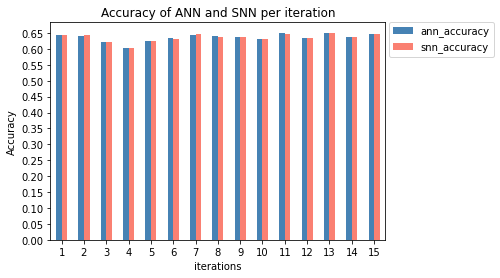

In [6]:
data = {
        'iterations': [x for x in range(1, len(ann) + 1)],
        'ann_accuracy': ann,
        'snn_accuracy': snn
    }

df = pd.DataFrame(data=data, index=(list(range(1, len(ann) + 1))))

print(df) 
df.to_excel(os.path.join('output', 'values.xlsx'))

ann_avg, snn_avg = statistics.mean(ann), statistics.mean(snn)
print('mean average of ann accuracy: {:4f}%\n'
      'mean average of snn accuracy: {:4f}%'
        .format(ann_avg*100, snn_avg*100))

colors = ['SteelBlue', 'Salmon']

df.plot(x='iterations', y=['ann_accuracy', 'snn_accuracy'],
    color=colors, kind='bar', title='Accuracy of ANN and SNN per iteration')
plt.yticks(np.arange(0, max(max(snn), max(ann)), 0.05))
plt.xticks(rotation=0)
plt.ylabel('Accuracy')

plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)

plt.savefig(os.path.join('output', 'graph.svg'), format='svg', bbox_inches='tight')
plt.show()